In [8]:
import pandas as pd
import numpy as np
#from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\PC\OneDrive\Dokumen\python_programming\kalman_filltering\data\podcast_wednesday.csv')
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Money Matters,Episode 87,28.06,Business,22.02,Wednesday,Morning,NaN,1,Neutral,13.913024
1,Tech Talks,Episode 72,85.73,Technology,57.22,Wednesday,Afternoon,50.33,1,Neutral,37.215150
2,Finance Focus,Episode 40,107.40,Business,61.43,Wednesday,Morning,42.50,1,Neutral,84.990195
3,Tune Time,Episode 63,55.46,Music,77.41,Wednesday,Night,46.44,0,Negative,55.460000
4,Fitness First,Episode 35,18.70,Health,54.88,Wednesday,Evening,32.13,0,Negative,9.607473


# 1. Kalman fillter cơ bản

Ước lượng Listening_Time_minutes dựa trên mô hình trạng thái đơn giản.

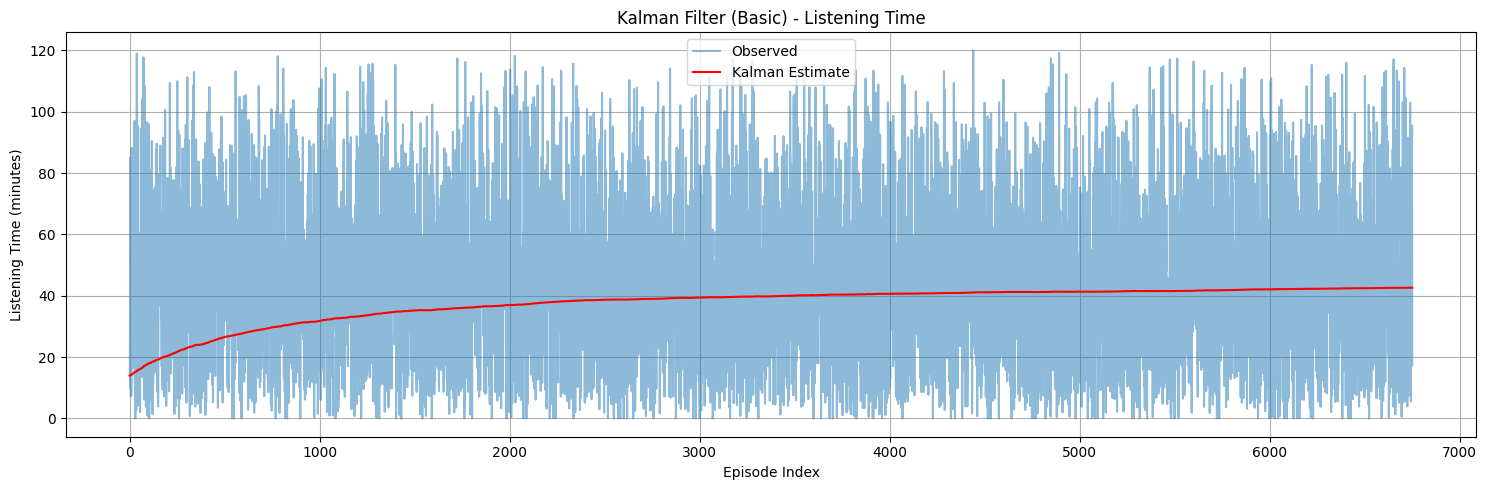

In [ ]:
# Giá trị thực tế
observations = df['Listening_Time_minutes'].dropna().values
n = len(observations)

# kalman param
Q = 1e-5
R = np.var(observations - np.mean(observations))
xhat = np.zeros(n)
P = np.zeros(n)
xhatminus = np.zeros(n)
Pminus = np.zeros(n)
K = np.zeros(n)

# Giá trị khởi tạo
xhat[0] = observations[0]
P[0] = 1.0

for k in range(1, n):
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1] + Q
    K[k] = Pminus[k] / (Pminus[k] + R)
    xhat[k] = xhatminus[k] + K[k] * (observations[k] - xhatminus[k])
    P[k] = (1 - K[k]) * Pminus[k]

# result
plt.figure(figsize=(15, 5))
plt.plot(observations, label='Observed', alpha=0.5)
plt.plot(xhat, label='Kalman Estimate', color='red')
plt.title('Kalman Filter (Basic) - Listening Time')
plt.xlabel('Episode Index')
plt.ylabel('Listening Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. Kalman filler with Trend

mô hình này không chỉ theo dõi giá trị hiện tại mà còn ước lượng được xu hướng

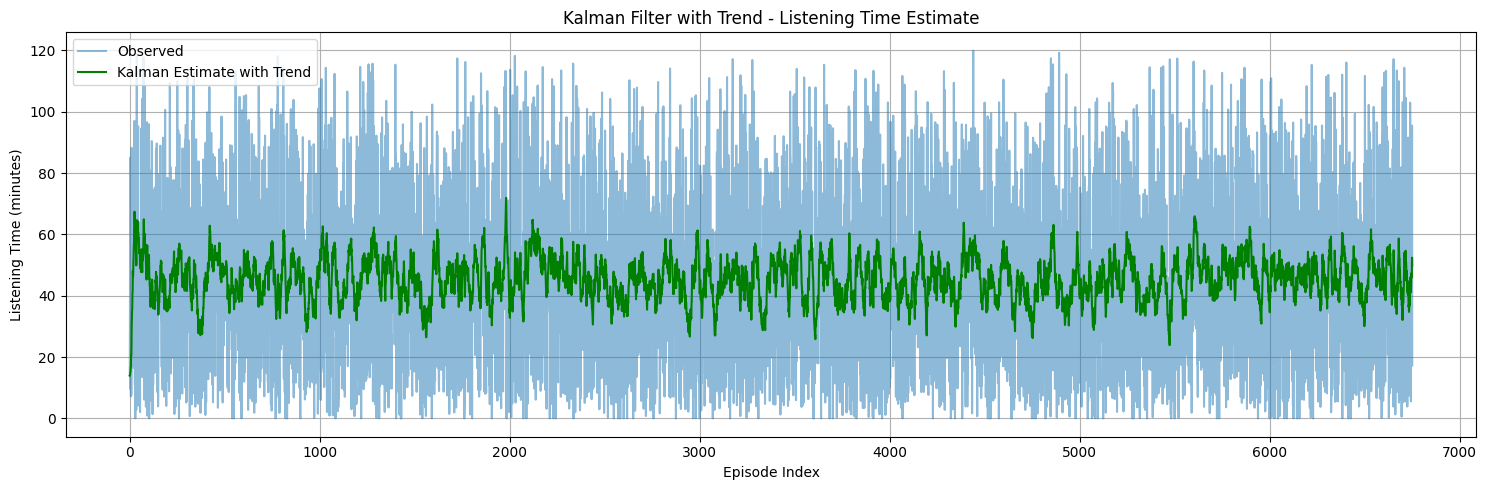

In [ ]:
# Giá trị thực tế
observations = df['Listening_Time_minutes'].dropna().values
n = len(observations)

# Ma trận hệ số
A = np.array([[1, 1], [0, 1]])  # Trạng thái gồm giá trị và xu hướng
H = np.array([[1, 0]])          # Chỉ quan sát giá trị

# Khởi tạo các biến
x_est = np.zeros((n, 2))        # Trạng thái ước lượng [giá trị, xu hướng]
P = np.zeros((n, 2, 2))         # Ma trận hiệp phương sai
Q = np.eye(2) * 0.01            # Nhiễu quá trình
R = np.array([[np.var(observations)]])  # Nhiễu quan sát
I = np.eye(2)

# Giá trị ban đầu
x_est[0] = [observations[0], 0]
P[0] = np.eye(2)

# Thuật toán Kalman
for k in range(1, n):
    # Dự đoán
    x_pred = A @ x_est[k-1]
    P_pred = A @ P[k-1] @ A.T + Q

    # Kalman Gain
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    # Cập nhật
    y = observations[k] - H @ x_pred
    x_est[k] = x_pred + K.flatten() * y
    P[k] = (I - K @ H) @ P_pred

# result
plt.figure(figsize=(15, 5))
plt.plot(observations, label='Observed', alpha=0.5)
plt.plot(x_est[:, 0], label='Kalman Estimate with Trend', color='green')
plt.title('Kalman Filter with Trend - Listening Time Estimate')
plt.xlabel('Episode Index')
plt.ylabel('Listening Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. Kalman

In [ ]:
# Lấy dữ liệu
obs = df[['Listening_Time_minutes', 'Episode_Length_minutes']].dropna()
z = obs['Listening_Time_minutes'].values
u = obs['Episode_Length_minutes'].values
n = len(z)

# Khởi tạo tham số
xhat = np.zeros(n)  # trạng thái ẩn
P = np.zeros(n)     # hiệp phương sai
Q = 1e-5            # nhiễu quá trình
R = np.var(z)       # nhiễu quan sát
H = 1.0             # hệ số trạng thái
B = 0.5             # hệ số tác động của biến phụ (có thể điều chỉnh)
xhat[0] = z[0]
P[0] = 1.0

# Kalman Filter có input phụ
for k in range(1, n):
    # Dự đoán
    xhat_minus = xhat[k-1]
    P_minus = P[k-1] + Q

    # Tính sai số đo
    y = z[k] - (H * xhat_minus + B * u[k])  # residual

    # Kalman Gain
    K = P_minus * H / (H * P_minus * H + R)

    # Cập nhật
    xhat[k] = xhat_minus + K * y
    P[k] = (1 - K * H) * P_minus

# result
plt.figure(figsize=(15, 5))
plt.plot(z, label='Observed', alpha=0.5)
plt.plot(xhat + B * u, label='Kalman with Episode Length input', color='purple')
plt.title('Kalman Filter with External Input (Episode Length)')
plt.xlabel('Episode Index')
plt.ylabel('Listening Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
